# PyTorch ANN on Engineered Features from Windowed Data

This notebook uses an artificial neural network in Pytorch to classify windows of data using features manually extracted from those windows.

We will see if using those features to train gives a more accurate model than training on individual timepoints.

__INPUT: .csv files which when read in give a dataframe where each row is a collection of features extracted from a 20s window with 10s overlap. Each different feature is stored in a column  (engineered_features.csv)__

## Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import sklearn
import sklearn.metrics as metrics
import random
import torch
from torch import nn
import torch.nn.functional as F
from keras.utils import to_categorical
from keras.utils import np_utils
import random
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score

random.seed(999)

## Read in data

The loaded dataset contains windows of data that are 20 seconds long with a 10 second overlap. These are stored as arrays in the dataframe.

In [2]:
pd.set_option('display.max_columns', None)
df = pd.read_csv('engineered_features.csv')

We add a window number that changes everytime there is a new activity present, as we wish to use this as a feature.

In [3]:
df = df.assign(count=df.groupby(df.Activity.ne(df.Activity.shift()).cumsum()).cumcount().add(1))

In [4]:
df.head(5)
#what the sensor names correspond to
#['ACC1', 'ACC2', 'ACC3','TEMP', 'EDA', 'HR', 'BVP', 'Magnitude',] 
#Accelerometry Axes, Body Temperature, Electrodermal Activity, Heart Rate, Blood Volume Pulse, Magnitude of Axes

,ACC1,ACC2,ACC3,TEMP,EDA,BVP,HR,Magnitude,Subject_ID,Activity,Round,ACC1_mean,ACC2_mean,ACC3_mean,TEMP_mean,EDA_mean,BVP_mean,HR_mean,Magnitude_mean,ACC1_std,ACC2_std,ACC3_std,TEMP_std,EDA_std,BVP_std,HR_std,Magnitude_std,ACC1_skew,ACC2_skew,ACC3_skew,TEMP_skew,EDA_skew,BVP_skew,HR_skew,Magnitude_skew,ACC1_min,ACC2_min,ACC3_min,TEMP_min,EDA_min,BVP_min,HR_min,Magnitude_min,ACC1_max,ACC2_max,ACC3_max,TEMP_max,EDA_max,BVP_max,HR_max,Magnitude_max,count
0,[41.0 41.0 41.0 41.0 41.0 41.0 41.0 41.0 41.0 ...,[27.2 27.3 27.4 27.5 27.6 27.7 27.8 27.9 28.0 ...,[40.0 40.0 40.0 40.0 40.0 40.0 40.0 40.0 40.0 ...,[32.39 32.39 32.39 32.39 32.34 32.34 32.34 32....,[0.275354 0.276634 0.270231 0.270231 0.26895 0...,[15.25 -12.75 -42.99 18.39 13.61 -9.66 -35.47 ...,[78.98 78.83500000000002 78.69 78.545 78.4 78....,[63.410093833710725 63.453053512025726 63.4961...,19-001,Baseline,1,40.248370,28.012880,38.824457,32.350,0.262354,-0.109875,73.931187,62.553853,0.701573,0.687590,0.632616,0.017607,0.004877,18.439453,2.574676,0.609756,-0.082592,-0.558848,0.705668,0.714533,0.896382,-0.392823,0.296262,0.531557,39.0,26.456522,38.0,32.33,0.254862,-42.99,69.7650,61.692787,41.543478,29.0,40.0,32.39,0.276634,34.83,78.98,63.757353,1
1,[39.0 39.06521739130435 39.130434782608695 39....,[29.0 28.93478260869565 28.869565217391305 28....,[38.0 38.02173913043478 38.04347826086956 38.0...,[32.34 32.34 32.34 32.34 32.33 32.33 32.33 32....,[0.25998499999999997 0.25998499999999997 0.258...,[-18.83 -0.3 11.03 6.09 -15.3 14.61 6.75 -2.38...,[73.52 73.435 73.35 73.265 73.18 73.0925 73.00...,[61.69278726074872 61.7168170027034 61.7409828...,19-001,Baseline,1,40.820000,26.815000,38.192500,32.339,0.261058,0.321375,69.481750,62.021872,1.192214,1.149559,0.529382,0.012610,0.003007,20.104717,2.608254,0.542348,0.515544,0.109446,-0.188071,0.787066,0.212943,-0.322900,-0.170923,-0.438037,39.0,24.600000,37.2,32.31,0.254862,-48.52,64.8025,60.778286,43.800000,29.0,39.0,32.37,0.266389,37.72,73.52,62.936476,2
2,[41.60869565217392 41.67391304347826 41.739130...,[26.39130434782609 26.32608695652174 26.260869...,[38.869565217391305 38.89130434782609 38.91304...,[32.34 32.34 32.34 32.34 32.33 32.33 32.33 32....,[0.265108 0.263827 0.266389 0.265108 0.266389 ...,[-27.69 30.51 14.64 1.97 -13.65 -48.52 17.77 2...,[69.63 69.515 69.4 69.285 69.17 69.04 68.91 68...,[62.758486272725364 62.78782873035957 62.81730...,19-001,Baseline,1,43.252235,25.312684,37.488043,32.337,0.259585,0.684000,64.893188,62.621785,2.109896,0.815025,0.647914,0.010536,0.004337,23.756276,2.639037,0.942868,-0.473020,0.227966,1.329886,0.620801,0.072564,-0.274279,0.185657,-0.382833,39.0,24.000000,37.0,32.31,0.252301,-48.52,60.9950,60.778286,45.532258,27.0,39.0,32.37,0.266389,47.14,69.63,64.010791,3
3,[43.971428571428575 44.14285714285715 44.31428...,[24.514285714285712 24.42857142857143 24.34285...,[37.17142857142857 37.142857142857146 37.11428...,[32.33 32.33 32.33 32.33 32.34 32.34 32.34 32....,[0.258704 0.258704 0.258704 0.257424 0.257424 ...,[17.18 2.41 -22.11 5.12 18.43 5.34 -14.33 -22....,[64.68 64.555 64.43 64.305 64.18 64.0475 63.91...,[62.579164557660036 62.649331804179724 62.7200...,19-001,Baseline,1,44.905798,24.915984,37.638218,32.356,0.254510,-0.180875,61.157687,63.734171,1.832017,1.509593,1.773398,0.025377,0.002396,25.635645,1.674001,0.841361,-4.941414,-1.040349,3.435987,0.672586,0.734482,-0.828441,0.406263,-0.532117,32.0,20.985816,37.0,32.33,0.251020,-101.74,58.8025,61.392182,46.000000,27.0,48.0,32.41,0.262546,47.14,64.68,65.711491,4
4,[45.54838709677418 45.564516129032256 45.58064...,[25.64516129032258 25.69354838709677 25.741935...,[37.0 37.0 37.0 37.0 37.0 37.0 37.0 37.0 37.0 ...,[32.34 32.34 32.34 32.34 32.33 32.33 32.33 32....,[0.253581 0.253581 0.253581 0.252301 0.252301 ...,[-32.0 15.14 24.41 3.88 -22.97 -0.34 17.89 3.0...,[60.92 60.8475 60.77500000000001 60.7025 60.63...,[64.04162603123257 64.07248675362091 64.103373...,19-001,Baseline,1,43.577055,22.974382,38.971144,32.389,0.252733,-0.209750,59.226438,62.913

### Label Encode Activity and Subject_ID

We encode the y variable as we need to one-hot encode this y variable for the model. The label each class is associated with is printed below.

In [5]:
from sklearn.preprocessing import LabelEncoder
le1 = LabelEncoder()
df['Activity'] = le1.fit_transform(df['Activity'])

activity_name_mapping = dict(zip(le1.classes_, le1.transform(le1.classes_)))
print(activity_name_mapping)

{'Activity': 0, 'Baseline': 1, 'DB': 2, 'Type': 3}


In [6]:
le = LabelEncoder()
df['Subject_ID'] = le.fit_transform(df['Subject_ID'])

## Create train/val/test split

The validation and testing scheme for this notebook is to take a random sample of 40 subjects for the training set, validate on 5 subjects during training to assess overfitting during training epochs, and then to test on 10 subjects. There are 55 subjects total

Cross validation was not performed, but may be implemented in a future edition of this notebook.

In [7]:
#make a list of ID's in a random order
ID_list = list(df['Subject_ID'].unique())
random.shuffle(ID_list)

#initialize dataframes the splits go into
train = pd.DataFrame()
val = pd.DataFrame()
test = pd.DataFrame()

#decide sizes of splits by indexing into randomly ordered ID list. index != ID.
#splitting on ID allows us to generalize better if we were to have another subject's data
train = df[df['Subject_ID'].isin(ID_list[:40])]
val = df[df['Subject_ID'].isin(ID_list[40:45])]
test = df[df['Subject_ID'].isin(ID_list[45:])]

# Feature Selection

### Features that can be used in the model

Picking one of the three following code cells to chooses what features are used in the model. For this model, we chose to use all features. You can request the code to choose to run the model on different features.

##### All Features

In [8]:
train = train[['ACC1_mean', 'ACC2_mean', 'ACC3_mean', 'TEMP_mean', 'EDA_mean', 'BVP_mean', 'HR_mean', 'Magnitude_mean', 'ACC1_std', 'ACC2_std', 
                'ACC3_std', 'TEMP_std', 'EDA_std', 'BVP_std', 'HR_std', 'Magnitude_std', 'ACC1_min', 'ACC2_min', 'ACC3_min', 'TEMP_min', 'EDA_min', 'BVP_min', 'HR_min', 'Magnitude_min', 
                'ACC1_max', 'ACC2_max', 'ACC3_max', 'TEMP_max', 'EDA_max', 'BVP_max', 'HR_max', 'Magnitude_max', 'Subject_ID', 'count', 'Activity']]   

val = val [['ACC1_mean', 'ACC2_mean', 'ACC3_mean', 'TEMP_mean', 'EDA_mean', 'BVP_mean', 'HR_mean', 'Magnitude_mean', 'ACC1_std', 'ACC2_std', 
               'ACC3_std', 'TEMP_std', 'EDA_std', 'BVP_std', 'HR_std', 'Magnitude_std', 'ACC1_min', 'ACC2_min', 'ACC3_min', 'TEMP_min', 'EDA_min', 'BVP_min', 'HR_min', 'Magnitude_min', 
               'ACC1_max', 'ACC2_max', 'ACC3_max', 'TEMP_max', 'EDA_max', 'BVP_max', 'HR_max', 'Magnitude_max', 'Subject_ID', 'count', 'Activity']]

test = test [['ACC1_mean', 'ACC2_mean', 'ACC3_mean', 'TEMP_mean', 'EDA_mean', 'BVP_mean', 'HR_mean', 'Magnitude_mean', 'ACC1_std', 'ACC2_std', 
               'ACC3_std', 'TEMP_std', 'EDA_std', 'BVP_std', 'HR_std', 'Magnitude_std', 'ACC1_min', 'ACC2_min', 'ACC3_min', 'TEMP_min', 'EDA_min', 'BVP_min', 'HR_min', 'Magnitude_min', 
               'ACC1_max', 'ACC2_max', 'ACC3_max', 'TEMP_max', 'EDA_max', 'BVP_max', 'HR_max', 'Magnitude_max', 'Subject_ID', 'count', 'Activity']]


feature_list = ['ACC1_mean', 'ACC2_mean', 'ACC3_mean', 'TEMP_mean', 'EDA_mean', 'BVP_mean', 'HR_mean', 'Magnitude_mean', 'ACC1_std', 'ACC2_std', 
                'ACC3_std', 'TEMP_std', 'EDA_std', 'BVP_std', 'HR_std', 'Magnitude_std', 'ACC1_min', 'ACC2_min', 'ACC3_min', 'TEMP_min', 'EDA_min', 'BVP_min', 'HR_min', 'Magnitude_min', 
                'ACC1_max', 'ACC2_max', 'ACC3_max', 'TEMP_max', 'EDA_max', 'BVP_max', 'HR_max', 'Magnitude_max',]



##### Mechanical Features

In [9]:
# train = train[['ACC1_mean', 'ACC2_mean', 'ACC3_mean', 'Magnitude_mean', 'ACC1_std', 'ACC2_std',  'ACC3_std', 'Magnitude_std',
#                'ACC1_min', 'ACC2_min', 'ACC3_min', 'Magnitude_min', 
#                'ACC1_max', 'ACC2_max', 'ACC3_max', 'Magnitude_max', 'Subject_ID', 'count', 'Activity']]   

# val = val[['ACC1_mean', 'ACC2_mean', 'ACC3_mean', 'Magnitude_mean', 'ACC1_std', 'ACC2_std',  'ACC3_std', 'Magnitude_std',
#                'ACC1_min', 'ACC2_min', 'ACC3_min', 'Magnitude_min', 
#                'ACC1_max', 'ACC2_max', 'ACC3_max', 'Magnitude_max', 'Subject_ID', 'count', 'Activity']]   
               
# test = test[['ACC1_mean', 'ACC2_mean', 'ACC3_mean', 'Magnitude_mean', 'ACC1_std', 'ACC2_std',  'ACC3_std', 'Magnitude_std',
#                 'ACC1_min', 'ACC2_min', 'ACC3_min', 'Magnitude_min', 
#                'ACC1_max', 'ACC2_max', 'ACC3_max', 'Magnitude_max', 'Subject_ID', 'count', 'Activity']]

# feature_list = ['ACC1_mean', 'ACC2_mean', 'ACC3_mean', 'Magnitude_mean', 'ACC1_std', 'ACC2_std',  'ACC3_std', 'Magnitude_std',
#                 'ACC1_min', 'ACC2_min', 'ACC3_min', 'Magnitude_min', 
#                'ACC1_max', 'ACC2_max', 'ACC3_max', 'Magnitude_max', 'Subject_ID', 'count',]

##### Physiological Features

In [10]:
# train = train[['TEMP_mean', 'EDA_mean', 'BVP_mean', 'HR_mean', 'TEMP_std', 'EDA_std', 'BVP_std', 'HR_std', 'TEMP_min', 'EDA_min', 'BVP_min', 'HR_min', 
#                 'TEMP_max', 'EDA_max', 'BVP_max', 'HR_max', 'Subject_ID', 'count', 'Activity']]   

# val = val[['TEMP_mean', 'EDA_mean', 'BVP_mean', 'HR_mean', 'TEMP_std', 'EDA_std', 'BVP_std', 'HR_std', 'TEMP_min', 'EDA_min', 'BVP_min', 'HR_min', 
#                 'TEMP_max', 'EDA_max', 'BVP_max', 'HR_max', 'Subject_ID', 'count', 'Activity']]   

# test = test[['TEMP_mean', 'EDA_mean', 'BVP_mean', 'HR_mean', 'TEMP_std', 'EDA_std', 'BVP_std', 'HR_std', 'TEMP_min', 'EDA_min', 'BVP_min', 'HR_min', 
#                 'TEMP_max', 'EDA_max', 'BVP_max', 'HR_max', 'Subject_ID', 'count', 'Activity']]

# feature_list = ['TEMP_mean', 'EDA_mean', 'BVP_mean', 'HR_mean', 'TEMP_std', 'EDA_std', 'BVP_std', 'HR_std', 'TEMP_min', 'EDA_min', 'BVP_min', 'HR_min', 
#                 'TEMP_max', 'EDA_max', 'BVP_max', 'HR_max', 'Subject_ID', 'count',]

### Balancing Classes

In the following code cells, we randomly sample data from our majority classes to balance our dataset.  

In [11]:
#{'Activity': 0, 'Baseline': 1, 'DB': 2, 'Type': 3}
train['Activity'].value_counts()

0    2262
1    1794
3     390
2     390
Name: Activity, dtype: int64

In [12]:
zero = train[train['Activity'] == 0]
one = train[train['Activity'] == 1]
two = train[train['Activity'] == 2]
three =train[train['Activity'] == 3]

In [13]:
zero = zero.sample(380)
one = one.sample(380)

In [14]:
train = pd.concat([zero, one, two, three])

In [15]:
train['Activity'].value_counts()

3    390
2    390
1    380
0    380
Name: Activity, dtype: int64

### Apply one-hot encoding to Subject ID and window count

Subject_ID and window count must be one-hot encoded to be used as features in our model. Test and train dataframes must be concatenated before we one-hot encode, so that we do not get different encodings for each data set.

In [16]:
train['train'] =1
test['train'] = 0

combined = pd.concat([train, test])
combined = pd.concat([combined, pd.get_dummies(combined['Subject_ID'], prefix = 'SID')], axis =1).drop('Subject_ID', axis =1)
combined = pd.concat([combined, pd.get_dummies(combined['count'], prefix = 'count')], axis =1).drop('count', axis = 1)

In [17]:
train = combined[combined['train'] == 1]
test = combined[combined['train'] == 0]

train.drop(["train"], axis = 1, inplace = True)
test.drop(["train"], axis = 1, inplace = True)
print(train.shape, test.shape)

(1540, 141) (1240, 141)


/Users/N1/opt/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


We remove activity from our train and test datasets as this is the y variable (target variable) and we are only interested in keeping the features. 

In [18]:
train_f = train.drop("Activity", axis =1)
test_f = test.drop("Activity", axis =1)

### Seperate data from labels

In [19]:
X_train = train_f
y_train = train.Activity
X_test = test_f
y_test = test.Activity
X_val = test_f
y_val = test.Activity

#the data (X) is used to predict the labels (y) in each split (train, val, test)

In [20]:
train

,ACC1_mean,ACC2_mean,ACC3_mean,TEMP_mean,EDA_mean,BVP_mean,HR_mean,Magnitude_mean,ACC1_std,ACC2_std,ACC3_std,TEMP_std,EDA_std,BVP_std,HR_std,Magnitude_std,ACC1_min,ACC2_min,ACC3_min,TEMP_min,EDA_min,BVP_min,HR_min,Magnitude_min,ACC1_max,ACC2_max,ACC3_max,TEMP_max,EDA_max,BVP_max,HR_max,Magnitude_max,Activity,SID_0,SID_1,SID_2,SID_3,SID_4,SID_5,SID_7,SID_8,SID_9,SID_10,SID_11,SID_13,SID_14,SID_15,SID_16,SID_17,SID_18,SID_19,SID_21,SID_22,SID_23,SID_24,SID_25,SID_26,SID_27,SID_28,SID_29,SID_30,SID_31,SID_32,SID_33,SID_34,SID_35,SID_36,SID_37,SID_38,SID_39,SID_40,SID_41,SID_42,SID_43,SID_44,SID_46,SID_47,SID_48,SID_49,SID_50,SID_51,SID_52,SID_54,count_1,count_2,count_3,count_4,count_5,count_6,count_7,count_8,count_9,count_10,count_11,count_12,count_13,count_14,count_15,count_16,count_17,count_18,count_19,count_20,count_21,count_22,count_23,count_24,count_25,count_26,count_27,count_28,count_29,count_30,count_31,count_32,count_33,count_34,count_35,count_36,count_37,count_38,count_39,count_40,count_41,count_42,count_43,count_44,count_45,count_46,count_47,count_48,count_49,count_50,count_51,count_52,count_53,count_54,count_55,count_56,count_57,count_58
3109,32.477125,53.204490,17.119954,33.3620,5.992753,0.310250,89.166813,64.679448,1.435731,1.078247,1.293905,0.015033,0.051317,21.320308,0.491530,0.203493,30.000000,51.122449,15.000000,33.34,5.883060,-44.69,88.3800,64.420494,35.040816,55.000000,19.653061,33.39,6.061079,69.85,89.7500,65.193268,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5721,-13.939318,-68.764545,-2.886136,33.4290,11.322016,1.462750,106.243312,70.344281,2.273211,9.471252,3.236131,0.036042,0.234223,43.180419,0.035726,9.392756,-18.000000,-83.000000,-8.400000,33.37,10.985124,-102.14,106.1800,55.812185,-9.000000,-55.000000,2.000000,33.49,11.734342,112.17,106.3000,84.728980,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2467,14.135417,71.229167,10.008333,32.8475,2.182960,-1.917000,94.035188,74.498945,10.930969,5.786738,8.741019,0.025471,0.278085,40.944605,0.454921,7.270209,-3.000000,56.000000,-2.000000,32.81,1.922986,-201.45,93.2200,56.258333,46.000000,85.000000,29.000000,32.89,2.991239,71.82,94.6600,89.308454,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
4928,22.117548,44.118029,40.976442,31.3610,6.279006,-0.144500,104.584063,67.205560,14.926901,17.135199,12.553408,0.014799,0.430848,6.785002,0.915095,16.494951,0.000000,14.000000,16.000000,31.33,5.608649,-15.07,103.4300,34.073450,66.000000,88.000000,77.000000,31.39,7.057137,30.38,106.5175,102.391406,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3142,54.576842,51.662105,4.542632,33.6480,13.055607,-0.028500,90.531750,75.291167,0.680612,0.145846,0.413229,0.011225,0.510624,24.031238,0.036216,0.368354,53.412632,51.412632,3.835789,33.63,11.940045,-57.21,90.4500,74.667786,55.741053,51.911579,5.249474,33.66,14.340009,63.01,90.5700,75.927840,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,..

### Scale data

In [21]:
#ignore pink box of suggestions when this runs

#scales the data to have a min of 0 and a max of 1

from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(-1,1))
for feature in feature_list:
    #scale train data
    temp_x_train = X_train[feature].to_numpy() 
    X_train[feature] = scaler.fit_transform(temp_x_train.reshape(-1, 1))
    
    #scale validation data
    temp_x_val = X_val[feature].to_numpy()
    X_val[feature] = scaler.fit_transform(temp_x_val.reshape(-1, 1))s
    
    #scale test data
    temp_x_test = X_test[feature].to_numpy()
    X_test[feature] = scaler.fit_transform(temp_x_test.reshape(-1, 1))
    
X_train #what it turns into

,ACC1_mean,ACC2_mean,ACC3_mean,TEMP_mean,EDA_mean,BVP_mean,HR_mean,Magnitude_mean,ACC1_std,ACC2_std,ACC3_std,TEMP_std,EDA_std,BVP_std,HR_std,Magnitude_std,ACC1_min,ACC2_min,ACC3_min,TEMP_min,EDA_min,BVP_min,HR_min,Magnitude_min,ACC1_max,ACC2_max,ACC3_max,TEMP_max,EDA_max,BVP_max,HR_max,Magnitude_max,SID_0,SID_1,SID_2,SID_3,SID_4,SID_5,SID_7,SID_8,SID_9,SID_10,SID_11,SID_13,SID_14,SID_15,SID_16,SID_17,SID_18,SID_19,SID_21,SID_22,SID_23,SID_24,SID_25,SID_26,SID_27,SID_28,SID_29,SID_30,SID_31,SID_32,SID_33,SID_34,SID_35,SID_36,SID_37,SID_38,SID_39,SID_40,SID_41,SID_42,SID_43,SID_44,SID_46,SID_47,SID_48,SID_49,SID_50,SID_51,SID_52,SID_54,count_1,count_2,count_3,count_4,count_5,count_6,count_7,count_8,count_9,count_10,count_11,count_12,count_13,count_14,count_15,count_16,count_17,count_18,count_19,count_20,count_21,count_22,count_23,count_24,count_25,count_26,count_27,count_28,count_29,count_30,count_31,count_32,count_33,count_34,count_35,count_36,count_37,count_38,count_39,count_40,count_41,count_42,count_43,count_44,count_45,count_46,count_47,count_48,count_49,count_50,count_51,count_52,count_53,count_54,count_55,count_56,count_57,count_58
3109,0.412339,0.516641,0.167235,0.112854,-0.843780,-0.217124,-0.224267,-0.414506,-0.948283,-0.965879,-0.958779,-0.919892,-0.968726,-0.891134,-0.908552,-0.989463,0.537031,0.628386,0.413791,0.115942,-0.844365,0.945227,-0.181086,0.104378,0.190893,0.308243,-0.132325,0.113703,-0.843441,-0.884336,-0.254457,-0.747070,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5721,-0.045755,-0.835361,-0.120355,0.132317,-0.704663,-0.173910,0.104906,-0.273567,-0.918116,-0.700285,-0.896903,-0.758856,-0.855126,-0.776237,-0.997912,-0.508857,0.070085,-0.590909,0.179162,0.124638,-0.709390,0.872805,0.181698,-0.059484,-0.196603,-0.748609,-0.318534,0.142857,-0.696526,-0.812920,0.056108,-0.495090,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2467,0.231321,0.716441,0.065004,-0.036601,-0.943232,-0.300637,-0.130422,-0.170200,-0.606251,-0.816880,-0.721528,-0.839887,-0.827884,-0.787988,-0.915729,-0.619868,0.216005,0.672727,0.243334,-0.037681,-0.949128,0.747614,-0.082442,-0.050991,0.287318,0.596475,-0.033731,-0.032070,-0.922937,-0.881012,-0.162319,-0.436022,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
4928,0.310098,0.415919,0.510174,-0.468410,-0.836308,-0.234176,0.072922,-0.351658,-0.462313,-0.457761,-0.600072,-0.921690,-0.733005,-0.967531,-0.825512,-0.137406,0.245190,0.290909,0.423818,-0.466667,-0.851624,0.982566,0.125650,-0.473287,0.463289,0.625298,0.472586,-0.469388,-0.817647,-0.950943,0.060190,-0.267272,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3142,0.630445,0.499544,-0.013566,0.195933,-0.659409,-0.229826,-0.197956,-0.150490,-0.975483,-0.995385,-0.986835,-0.949084,-0.683457,-0.876885,-0.997816,-0.980841,0.764790,0.631024,0.301849,0.200000,-0.684128,0.929444,-0.138897,0.299438,0.373025,0.278570,-0.284258,0.192420,-0.629050,-0.895879,-0.239069,-0.608611,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,

### Encode labels

In [22]:
#assigns the labels, which are currently strings, to numerical values, the form required for model interpretation

from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
y_train = le.fit_transform(y_train)
y_test = le.transform(y_test)
y_val = le.transform(y_val)


np.unique(y_train) #here's what it turns into

array([0, 1, 2, 3])

In [23]:
X_train.shape


(1540, 140)

### Initializing the model

The model is a fully connected (dense) feedforward neural network, or an artificial neural network. This code initializes the model, it does not run it.

The 140 nodes as input reflect the amount of features that enter the model. The output of four reflects the number of different activities

In [24]:
# define the network class
class DenseHAR(nn.Module):
    
    def __init__(self):
        # call constructor from superclass
        super().__init__()
        
        # define network layers
        self.fc1 = nn.Linear(140, 16) #num_sensors is a variable defined where the activity list is
        self.fc2 = nn.Linear(16, 32)
        self.fc3 = nn.Linear(32, 64)
        self.fc4 = nn.Linear(64, 32)  
        self.fc5 = nn.Linear(32,4)
        
    def forward(self, x):
        # define forward pass
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = F.relu(self.fc4(x))
        x = self.fc5(x)
        return x

# instantiate the model
model = DenseHAR()

# print model architecture
print(model)

DenseHAR(
  (fc1): Linear(in_features=140, out_features=16, bias=True)
  (fc2): Linear(in_features=16, out_features=32, bias=True)
  (fc3): Linear(in_features=32, out_features=64, bias=True)
  (fc4): Linear(in_features=64, out_features=32, bias=True)
  (fc5): Linear(in_features=32, out_features=4, bias=True)
)


### Further format data and check what we did

In [25]:
#needs to be like this to input to DataLoader later
X_train = X_train.values
X_test = X_test.values
X_val = X_val.values

In [26]:
print(X_train.shape, y_train.shape) #verify that amount of datapoints matches the amount of labels 

(1540, 140) (1540,)


In [27]:
#here's what a datapoint and label pair looks like
#the array as a whole corresponds to the single label

print(X_train[0])
print()
print(y_train[0])


[ 0.41233857  0.51664104  0.16723473  0.11285403 -0.84378021 -0.21712435
 -0.22426706 -0.41450644 -0.94828298 -0.96587912 -0.95877866 -0.91989178
 -0.96872646 -0.89113363 -0.90855192 -0.98946305  0.53703081  0.6283859
  0.41379123  0.11594203 -0.84436465  0.94522672 -0.18108631  0.10437769
  0.1908926   0.30824278 -0.13232493  0.11370262 -0.8434407  -0.88433629
 -0.25445675 -0.74707007  0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  1.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0

### Make Dataloader

In [28]:
import torch
import torchvision
from torch.utils.data import Dataset, DataLoader
import numpy as np
import math
from torch.autograd import Variable

#a dataloader sets up our data to be input into a pytorch model

def make_loader(X_dataset, y_dataset, batch_size, shuffle): #function to make a dataloader
    
    class LOAD_UP(Dataset): #turns function input dataset into an object the DataLoader constructor can understand
                            
        def __init__(self):
            self.x = torch.from_numpy(X_dataset[:, 0:])
            self.y = torch.from_numpy(y_dataset)
            self.n_samples = X_dataset.shape[0]
    
        def __getitem__(self,index):
            return self.x[index], self.y[index]
    
        def __len__(self):
            return self.n_samples

    dataset = LOAD_UP() #makes the object
    return DataLoader(dataset = dataset, 
                      shuffle = shuffle, #if you want inputs to be in a random order. we want this.
                      batch_size = batch_size, #how many the dataloader feeds in at a time
                      num_workers = 4)


train_loader = make_loader(X_train, y_train, 40, True) #making loaders for each dataset that will go into the model
test_loader = make_loader(X_test, y_test, len(X_test), True) #batch size for the following is the same as the length because we want everything fed in at once
val_loader = make_loader(X_val, y_val, len(X_val), True)

### Training and validating

We decided to use ADAM as our optimizer as it is computationally efficient and updates the learning rate on a per-parameter basis, based on a moving estimate per-parameter gradient, and the per-parameter squared gradient. 

Our loss function is a cross entropy loss since we are doing multiclass classification.

In [30]:
# Loss
criterion = nn.CrossEntropyLoss()

# Optimizer
opt = torch.optim.Adam(model.parameters(), lr=0.001)

#initialize variables
train_total = 0 
train_correct = 0
train_acc = 0
running_loss = 0

for epoch in range(10): #how many times we go through the data
    
    for v, val_data in enumerate(val_loader):
        
        for i, data in enumerate(train_loader):
            # unpack data in dataloader to the inputs and labels
            inputs, labels = data
        
            # variable
            inputs, labels = Variable(inputs), Variable(labels)
       
            # Forward pass: Compute predic y by passing x through model
            y_pred = model(inputs.float())
        
            # Loss
            loss = criterion(y_pred, labels)
            #print(epoch, i, loss.data[0])
        
            # Zero the gradients, backward pass, update weights
            opt.zero_grad()
            loss.backward()
            opt.step()

            # Compute Loss and Accuracy      
            running_loss += loss.item()
            
            #get the actual prediction
            scores, prediction = torch.max(y_pred.data, 1)
            
            
            #add the amount got right in the batch to the total got right for the epoch
            train_correct += int(sum(prediction == labels))
            
            
        train_acc = train_correct/len(y_train) #calcualte training accuracy: amount right/amount of labels
        
        #using the validation dataloader, first unpacking the data
        val_inputs, val_labels = val_data
        
        #variable?
        val_inputs, val_labels = Variable(val_inputs), Variable(val_labels)
        
        #use the model to get 
        y_val_pred = model(val_inputs.float())
        
        #calculate
        val_loss = criterion(y_val_pred, val_labels) #y_val_pred has 4 values, one for each potential class
        val_scores, val_prediction = torch.max(y_val_pred.data, 1) #taking softmax of the model's output to get most likely class
        val_acc = int(sum(val_prediction == val_labels))/len(val_labels) #how many predictions match up with labels divided by total number of labels

    # Print training and validation accuracy per epoch 
    print(f'Epoch: {epoch+1}\n training loss: {running_loss/len(train_loader):.5f}, training acc: {train_acc}')
    print(f'validation loss: {val_loss:.5f}, validation acc: {val_acc}')
    
    train_total = 0
    train_correct = 0
    train_acc = 0
    running_loss = 0

print('Finished Traning')

Epoch: 1
 training loss: 0.29367, training acc: 0.9058441558441559
validation loss: 0.52723, validation acc: 0.7895161290322581
Epoch: 2
 training loss: 0.27778, training acc: 0.9064935064935065
validation loss: 0.47655, validation acc: 0.8032258064516129
Epoch: 3
 training loss: 0.26818, training acc: 0.912987012987013
validation loss: 0.47105, validation acc: 0.8145161290322581
Epoch: 4
 training loss: 0.25702, training acc: 0.9181818181818182
validation loss: 0.54433, validation acc: 0.7911290322580645
Epoch: 5
 training loss: 0.25408, training acc: 0.9175324675324675
validation loss: 0.52662, validation acc: 0.7967741935483871
Epoch: 6
 training loss: 0.23531, training acc: 0.9298701298701298
validation loss: 0.52135, validation acc: 0.7959677419354839
Epoch: 7
 training loss: 0.22422, training acc: 0.9285714285714286
validation loss: 0.50145, validation acc: 0.8040322580645162
Epoch: 8
 training loss: 0.22010, training acc: 0.9305194805194805
validation loss: 0.50948, validation a

### Demonstration of output of model before softmax

In [31]:
#for educational purposes

def check_validation(index): #shows how the biggest value position in the model output usually corresponds to what label the data actually has
    print(y_val_pred[index])
    print(val_labels[index])
check_validation(3) #change this around to explore what the model did with individual validation datapoints

#see how the prediction (1) matches up with the index of the largest value of the tensor

tensor([  7.4346,   0.5150,  -8.5238, -14.2709], grad_fn=<SelectBackward>)
tensor(0)


### Validation Confusion Matrix

Text(0.5, 1.0, 'Duke Data Rolled ANN - Confusion Matrix')

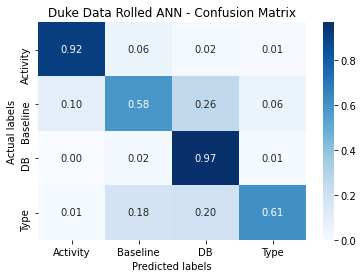

In [32]:
cm = sklearn.metrics.confusion_matrix(val_labels, val_prediction)
cm= cm.astype('float')/cm.sum(axis=1)[:,np.newaxis]

ax = plt.subplot()
sns.heatmap(cm, annot = True, fmt = '.2f',cmap = 'Blues', xticklabels = le1.classes_, yticklabels = le1.classes_)
ax.set_xlabel("Predicted labels")
ax.set_ylabel('Actual labels')
plt.title('Duke Data Rolled ANN - Confusion Matrix')


### Run model on the test set

In [38]:
test_total = 0
test_correct = 0
test_acc = []
for i, data in enumerate(test_loader):
        # inputs
        test_inputs, test_labels = data
        
        # variable
        test_inputs, test_labels = Variable(test_inputs), Variable(test_labels)
       
        # Forward pass: predict labels by passing inputs through model for test set
        y_pred = model(test_inputs.float())
        
        test_scores, test_prediction = torch.max(y_pred.data, 1)
        
        test_total += test_labels.size(0)
        test_correct += int(sum(test_prediction == test_labels))
        test_acc = test_correct/test_total
        f1_s = f1_score(test_labels, test_prediction, average = 'weighted')
        print(f1_s)

0.7811016588798528


### Test Accuracy and Confusion Matrix

In [35]:
test_acc

0.7733870967741936

Text(0.5, 1.0, 'Duke Data Rolled ANN - Confusion Matrix')

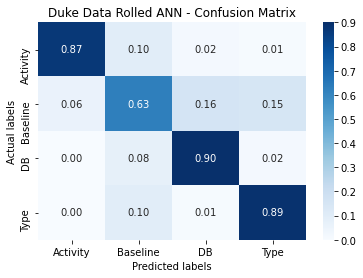

In [79]:
cm = metrics.confusion_matrix(test_labels, test_prediction.numpy())
cm = cm.astype('float')/cm.sum(axis=1)[:,np.newaxis]


ax = plt.subplot()
sns.heatmap(cm, annot = True, fmt = '.2f',cmap = 'Blues', xticklabels = le1.classes_, yticklabels = le1.classes_)
ax.set_xlabel("Predicted labels")
ax.set_ylabel('Actual labels')
plt.title('Duke Data Rolled ANN - Confusion Matrix')